### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

In [2]:
import numpy as np
from scipy import sparse
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D
import operator
from scipy.ndimage import binary_dilation
from functools import reduce
from sksparse.cholmod import cholesky
import matplotlib.animation as animation
from IPython.display import HTML, display
from time import clock

### Basic boundary conditions and visualization

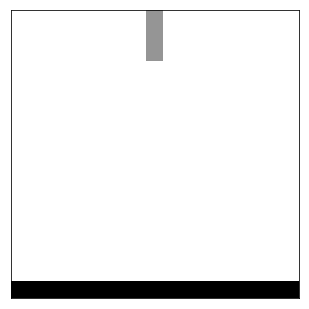

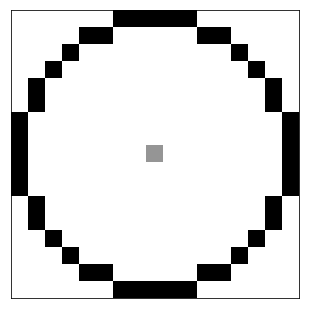

In [3]:
# Initial conditions with one negative charge in center of positive ellipse
def boundary1(shape):
    rs = np.array(shape) // 2
    dists = 0
    for i, r in enumerate(rs):
        idx = (None,) * i + (slice(None),) + (None,) * (len(shape) - i - 1)
        dists = (np.arange(-r, r + 1) ** 2 / r ** 2)[idx] + dists
    sphere = (np.sqrt(dists) - 1) * np.min(shape)
    b = np.where(np.abs(sphere) < 1, 1, np.nan)
    b = np.where(sphere > 1, np.nan, b)
    b[tuple(rs)] = 0
    return b


# initial conditions based on initial breakdown of size k
# Ground is a line of positive charge on bottom
def boundary2(shape, k=3):
    b = np.full(shape, np.nan)
    dims = len(shape)
    b = np.moveaxis(b, -1, 0)
    b[(shape[0] // 2,) * (dims - 1)][:k] = 0
    b[...,-1] = 1
    return np.moveaxis(b, -1, 0)

# Leader in the shape of a Z
def leader_z(n, k=3, z=0.1):
    b = np.zeros((n, n))
    d = np.ones(n)
    d = np.diag(d)
    d[[k, -k]] = 1
    d[:, :k] = 0
    d[:, -k:] = 0
    b[d == 1] = z
    b = np.fliplr(b)
    return b

# Boundary in the shape of a Z
def boundary_z(n, k=3):
    b = np.full((n, n), np.nan)
    b[k, -k] = 0
    b[-k, k] = 1
    b = np.fliplr(b)
    return b


def plot_config(b, name=None, **kwargs):
    b[b == 0] = 0.5
    b[np.isnan(b)] = 0
    fig, ax = plt.subplots(figsize=(2,2))
    fig.subplots_adjust(0,0,2,2)
    ax.imshow(b, cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    if name:
        plt.savefig(name, bbox_inches='tight', **kwargs)
    plt.show()
    plt.close()
    
%matplotlib inline
plot_config(boundary2((17, 17)))
plot_config(boundary1((17, 17)))

### Plotting functions for videos and interactive plots

In [4]:
# Plots 2d graph over time with interactive slider
def plot3d(volume, **kwargs):
    fig, ax = plt.subplots()
    ax.imshow(volume[0], vmin=np.min(volume), vmax=np.max(volume), **kwargs)
    def view_image(i):
        ax.images[0].set_array(volume[i])
        fig.canvas.draw()
    interact(view_image, i=(0, len(volume)-1))
    plt.show()
    
# Plots 3d scatter plot over time with interactive slider
def plot4d(time_volume, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    lims = time_volume.shape[1:]
    ax.scatter(*np.nonzero(time_volume[0] == 0), **kwargs)
    ax.set_xlim(0,lims[0])
    ax.set_ylim(0,lims[1])
    ax.set_zlim(0,lims[2])
    def view_image(i):
        ax.collections[0].remove()
        ax.scatter(*np.nonzero(time_volume[i] == 0), **kwargs)
        fig.canvas.draw_idle()
    interact(view_image, i=(0, len(time_volume)-1))
    plt.show()

# Plots 3d or 4d array using first axis as time
def plot_time(vol, **kwargs):
    vol = np.array(vol)
    if len(vol.shape) > 3:
        plot4d(vol, **kwargs)
    else:
        plot3d(vol, **kwargs)

# generates mp4 movie from 3d array volume, like plot3d
def movie(vol, iskwargs={}, interval=10, repeat_delay=1000, **kwargs):
    fig = plt.figure()
    plts = [[plt.imshow(A, **iskwargs)] for A in vol]
    ani = animation.ArtistAnimation(fig, plts, interval=interval, blit=True, repeat_delay=repeat_delay, **kwargs)
    return display(HTML(ani.to_html5_video()))

### Efficient solutions to poisson problem

In [5]:
# Generate sparse matrix for arbitrary-dimensional finite-difference laplacian
# http://jupiter.math.nctu.edu.tw/~smchang/0001/Poisson.pdf
# Can change step size of stencil with mul
def lapl(shape, mul=1, h=1):
    diags = [1, -2, 1] # Values on diagonals for 1d laplacian
    ks = [mul, 0, -mul] # which diagonals to set for above values
    
    # Store 1d laplacians T_j in array Ts
    Ts = [sparse.diags(diags, ks, shape=(j, j), format='csr') for j in shape]
    
    # Calculate kronsum (sum of tensor product of T_a, I_b and tensor product of I_a, T_b) of 1d laplacian matrices
    return reduce(lambda a, b: sparse.kronsum(a, b, format='csr'), Ts[::-1]) / h


# Returns function to solve Mz = r in pcg with incomplete poisson preconditioning
def IP_precond(A):
    L = sparse.tril(A)
    D = sparse.diags(1 / A.diagonal())
    K = sparse.eye(A.shape[0]) - L.dot(D)
    Minv = K.dot(K.T)
    return lambda r: Minv.dot(r)


# Factor A for L, U, P, D for incomplete Cholesky, PAP.T = LDU (approx)
def IC_factor(A, spilu=False, **kwargs):
    A_sp = A.copy()
    A_sp.data[:] = 1 # store sparsity pattern of A in A_sp
    try:
        # Factor with library if A is SPD
        factor = cholesky(A)
        L, D, P = (*factor.L_D(), factor.P())
        L = L.multiply(Acp) # enforce sparsity from A in L
        U = L.T
    except Exception as e:
        # Use LU if not SPD
        spl = linalg.spilu if spilu else linalg.splu
        # http://crd-legacy.lbl.gov/~xiaoye/SuperLU/superlu_ug.pdf
        ilu = spl(A, options={'ColPerm': 'NATURAL'}, **kwargs)
        D = sparse.eye(A.shape[0])
        L, U, P = ilu.L, ilu.U, ilu.perm_c
        if not spilu:
            # enforce sparsity from A in L and U
            L = L.multiply(A_sp)
            U = U.multiply(A_sp)
    return L, U, P, D        

# return function to solve Mz=r for z via forward and backward substitution from the above factorization
def IC_precond(A):
    Acp = A.copy()
    Acp.data[:] = 1
    L, U, P, D = IC_factor(A)
    Dinv = sparse.diags(1 / D.diagonal())
    # Invert permutation
    Pt = [i for i, j in sorted(enumerate(P), key=lambda j: j[1])]
    def get_z(r):
        PLz = Dinv.dot(linalg.spsolve_triangular(L, r[P]))
        return linalg.spsolve_triangular(U, PLz, lower=False)[Pt]
    return get_z

# Preconditioned conjugate gradient method given a preconditioning solve get_z
def pcg(x, b, A, get_z, min_err=1e-7):
    r = b - A.dot(x)
    z = get_z(r)
    p = z
    zr = z.T @ r
    while True:
        Ap = A.dot(p)
        pAp = p.T @ Ap
        if pAp == 0:
            raise Exception('Division by 0 in CG')
        alp = zr / pAp
        x += alp * p
        r -= alp * Ap
        if np.abs(zr) < min_err:
            break
        z = get_z(r)
        if zr == 0:
            raise Exception('Division by 0 in CG')
        beta = z.T @ r / zr
        p = z + beta * p
        zr *= beta
    return x

# Solve the poisson equation Lx=f by a variety of methods
def solve_poisson(L, f, x0=None, method='iccg'):
    if method in ['iccg', 'ipcg']:
        pc = IC_precond if method == 'iccg' else IP_precond
        return pcg(x0, f, L, pc(L))
    elif method == 'chol':
        try:
            # Fails if L is not SPD
            return cholesky(L)(f)
        except Exception:
            # Use LU if not SPD
            return linalg.splu(L, options={'ColPerm': 'NATURAL'}).solve(f)
    return linalg.inv(L).dot(f)


# Solves equation L*x=f with applied boundary conditions and solving poisson equation as above
def solve_lapl(bound, f, L, x0=None, solve_knowns=True, method='iccg'):
    f = f.copy()
    bound_flat = bound.flatten()
    bn = np.nan_to_num(bound_flat)
    f += L.dot(bn) # Add in influence of known values of L @ x to f
    
    unknown = np.isnan(bound_flat).astype(int)
    known_idx = np.where(1 - unknown)
    solve_idx = np.where(unknown)
    f[known_idx] = bound_flat[known_idx]
    
    # if solve_knowns, keep equations for known variables in system
    if solve_knowns:
        keep_rows = sparse.diags(unknown)
        L = keep_rows.dot(L).dot(keep_rows) - sparse.diags(1 - unknown)
        solve_idx = np.indices(bound_flat.shape)
    
    i = solve_idx[0]
    x0 = bn if x0 is None else x0
    bound_flat[i] = solve_poisson(L[i[:, None], i], -f[i], x0=x0[i], method=method)
    
    return bound_flat.reshape(bound.shape)

### Multigrid method with Guass siedel

In [6]:
# Gauss siedel method, red black or normal
def gauss_siedel(bound, u, A, f=None, n=500, use_red_black=True):
    bf = bound.flatten()
    f = f if f is not None else np.zeros_like(bf)
    u = u if u is not None else np.nan_to_num(bf)
    if use_red_black:
        # Only compute update at nonboundary
        nnz = np.nonzero(np.isnan(bound)) # nonboundary indices
        
        # determine red or black by parity of sum of indices for each square
        nnz += ([np.sum(a) for a in zip(*nnz)],)
        red_multi = [a[:-1] for a in zip(*nnz) if a[-1] % 2 == 0]
        black_multi = [a[:-1] for a in zip(*nnz) if a[-1] % 2 == 1]
        
        # flatten indices
        red = np.ravel_multi_index(list(zip(*red_multi)), bound.shape)
        black = np.ravel_multi_index(list(zip(*black_multi)), bound.shape)
        
        # alternate red-black for update n times
        for _ in range(n):
            for j in red:
                u[j] += (f[j] - A[j].dot(u)) / A[j, j]
            for j in black:
                u[j] += (f[j] - A[j].dot(u)) / A[j, j]
    else:
        # Only compute update at nonboundary
        nnz = np.nonzero(np.isnan(bf))[0]
        for _ in range(n):
            for j in nnz:
                u[j] += (f[j] - A[j].dot(u)) / A[j, j]
    
    # ensure boundary values still hold and reshape
    return np.where(np.isnan(bound), u.reshape(bound.shape), bound)

# Create interpolation operator along one axis of a grid
def interp1D(N, M):
    ns = np.arange(1, N - 1) * (M - 1) / (N - 1)
    cols = ns.astype(int)
    row_ind = np.hstack((np.arange(N - 1), np.arange(1, N)))
    col_ind = np.hstack(([0], cols, cols + 1, [M-1]))
    data = np.hstack(([1], cols + 1 - ns, ns - cols, [1]))
    return sparse.csr_matrix((data, (row_ind, col_ind)), shape=(N, M))


# Create restriction operator along one axis of a grid
def restrict1D(N, M):
    R = interp1D(N, M).T
    R /= np.sum(R[1])
    R[[0, -1]] = 0
    R[[0, -1], [0, -1]] = 1
    return R


# Arbitrary dimensional interpolation operator, constructed by kronecker product of 1d operators
def interp(s1, s2):
    return reduce(sparse.kron, (interp1D(N, M) for N, M in zip(s1, s2)))


# Arbitrary dimensional restriction operator, constructed by kronecker product of 1d operators
def restrict(s1, s2):
    return reduce(sparse.kron, (restrict1D(N, M) for N, M in zip(s1, s2)))


# Computes multigrid arrays for a problem (restriction and interpolation operators) just once
def get_mg_arrays(bound_shape, levels=3, v_up=2, v_down=0, scale=4, method='ipcg'):
    shapes = [bound_shape] + [tuple(np.array(bound_shape) // scale ** i + 1) for i in range(1, levels)]
    Rs = [restrict(shapes[i], shapes[i + 1]) for i in range(levels - 1)]
    Ts = [interp(shapes[i], shapes[i + 1]) for i in range(levels - 1)]
            
    # Traditional method, incompatible with conjugate gradient because not SPD
    # Ai = Rs[i-1].dot(As[-1]).dot(Ts[i - 1])
    # Instead just use laplacian of the proper shape
    As = [lapl(i) for i in shapes]
    
    # One full cycle of multigrid recursive algorithm using gauss siedel
    def solve_level(l, f, us, bounds):
        # If on the coarsest level solve by method
        if l == levels - 1:
            sol = solve_lapl(bounds[l], -f, As[l], x0=us[l], method=method).flatten()
            return [sol]
        
        # Smooth v_down times before restricting to coarser level
        sol = gauss_siedel(bounds[l], us[l], As[l], n=v_down).flatten()
        
        # Reapply boundary conditions
        sol = np.where(np.isnan(bounds[l].flatten()), sol, bounds[l].flatten())
        
        # Restrict solution to coarser level
        r = Rs[l].dot(f - As[l].dot(sol))
        
        # solve on coarser level
        sols = solve_level(l + 1, r, us, bounds)
        
        # Interpolate coarse solution to current level and normalize
        sol += Ts[l].dot(sols[0])
        sol /= np.max(sol)
        
        # Smooth v_up times with new solution
        sol = gauss_siedel(bounds[l], sol, As[l], n=v_up).flatten()
        
        # return all solutions (to be used as initial guesses with multiple v-cycles)
        return [sol] + sols
    
    return (shapes, Rs, solve_level)


# Solve multigrid for n cycles and with the given boundary
def multigrid(bound, f, u, mg_arrays=None, n=3, **kwargs):
    bounds = [bound]
    shapes, Rs, solve_level = mg_arrays if mg_arrays else get_mg_arrays(bound.shape, **kwargs)
    levels = len(shapes)
    
    # Apply restriction operator to bound to get bound at every level
    for i in range(1, levels):
        Ri = Rs[i - 1]
        xi = bounds[-1].flatten()
        boundi = np.where(Ri.dot(np.isnan(xi)) != 1, Ri.dot(np.nan_to_num(xi)), np.nan)
        bounds.append(boundi.reshape(shapes[i]))
    
    Us = [u]
    for i in range(1, levels):
        Us.append(Rs[i - 1].dot(Us[-1]) if Us[-1] is not None else None)
        
    # Use recursive solve_level function as above for n v-cycles
    for i in range(n):
        # Use solutions as initial guesses each v-cycle
        Us = solve_level(0, f.flatten(), Us, bounds)
        
    # Return final solution from Us on finest level (Us[0])
    return Us[0], bounds

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/usr/lib/python3.7/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


1.1934559999999999


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


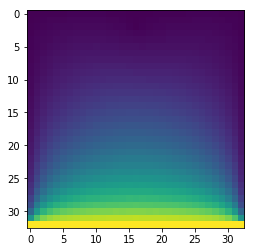

In [7]:
bound = boundary2((33, 33))
f = np.zeros_like(bound.flatten())
from time import clock
s = clock()
g = multigrid(bound, f, None, levels=3, scale=2, method='ipcg')[0].reshape(bound.shape)
print(clock() - s)
%matplotlib inline
plt.imshow(g)

### Classic DBM

In [8]:
# Add point to growth frontier of A with probabilities proportional to potential diff
def add_point(A, eta, force_pos=False):
    frontier = binary_dilation(A == 0) ^ (A == 0)
    frontier_idx = np.where(frontier)
    phis = A[frontier_idx] ** eta
    phis = phis if not force_pos else np.maximum(phis, 0)
    probs = phis / np.sum(phis)
    idxs = list(zip(*frontier_idx))
    return idxs[np.random.choice(len(idxs), p=probs)]


# Generate single leader with boundary b
def gen_arc(b, leader=None, eta=2, also=False, max_n=1000, h=1, mg=False, method='ipcg', mg_args={}):
    b = b.copy()
    f = np.zeros_like(b.flatten()) if leader is None else h ** 2 * leader.flatten()
    L = lapl(b.shape)
    
    # Solve with mutligred or solve lapl
    if mg:
        mg_args = {'scale': 4, 'method': method, **mg_args}
        levels = int(np.log(np.min(b.shape)) / np.log(mg_args.get('scale')))
        mg_args['levels'] = mg_args.get('levels', levels)
        print(levels, b.shape, mg_args)
        mg_arrays = get_mg_arrays(b.shape, **mg_args)
        solve = lambda B, U: multigrid(B, f, U, n=2, mg_arrays=mg_arrays)[0]
    else:
        solve = lambda B, U: solve_lapl(B, f, L, x0=U, method=method)
        
    Phis, Ts, bs = [], [], [b]
    Phi2s = []
    # Stop after max_n iterations
    for i in range(max_n):
        b = bs[-1].copy()
        
        # Solve for potential with laplacian pde
        prev = Phis[-1].flatten() if Phis else None
        Phi = solve(b, prev).reshape(b.shape)
        Phi = np.where(~np.isnan(b), b, Phi) # reapply boundary conditions
        
        # Append richardson error for adaptive mesh
        # Ts.append(richardson(Phi, L.dot(L) - lapl(b.shape, mul=2)))
        if also:
            b2 = b.copy()
            b2[:, [0, -1]] = 1
            Phi2 = solve(b2, Phi2s[-1].flatten() if Phi2s else None).reshape(b.shape)
            Phi2 = np.where(~np.isnan(b2), b2, Phi2)
            Phi2s.append(Phi2)
        
        # Randomly select growth point and add to boundary
        growth = add_point(Phi, eta, force_pos=True)
        if b[growth] == 1:
            break # End if we've reached the ground
        b[growth] = 0
        bs.append(b)
        
        # Re apply boundary conditions
        Phis.append(np.where(~np.isnan(b), b, Phi))
    return np.array(Phis, dtype=float), np.array(Phi2s, dtype=float) if also else None

# Generate multiple arcs with leaders, with rho as the influence of the previous leader
def gen_arcs(b, arcs, rho=1, **kwargs):
    Phis, lights, leader = [], [], None
    for i in range(arcs):
        # Generate arc
        Phi, bs = gen_arc(b, leader=leader, **kwargs)
        b_end = bs[-1]
        light = (np.array(Phi) == 0).astype(float)
        # Add in faded previous leader if it exists
        if lights:
            light = np.maximum(light, lights[-1][-1] / 4)
        
        # Append leader and phi
        Phis.append(Phi)
        lights.extend(light)
        
        # Calculate new leader for next iteration
        leader = np.where(b_end == 0, 4 * np.pi * rho, 0)
    return Phis, lights

In [9]:
from scipy.spatial.distance import cdist

# Calculate the distances of all the points in shape from point
def dists_from(shape, point):
    idxs = np.indices(shape).reshape(len(shape), np.prod(shape))
    return cdist([point], idxs.T).reshape(shape)


# Solve greens equation in 2d not 3d, polar laplacian with dirilecht boundary
def greens2d(R1, R2):
    lR1, lR2 = np.log(R1), np.log(R2)
    lRdiff = lR2 - lR1
    return lambda r: (np.log(r) - lR1) / lRdiff


# Solve greens in 3d per Lin paper
def greens3d(R1):
    return lambda r:  1 - R1 / r
    

# Calculate influence of point charge at point on grid with shape given function f
def phi_point(shape, point, f):
    phi = f(dists_from(shape, point))
    phi[phi == -np.inf] = 0
    return phi


# Sum all charges in a boundary with phi_point
def sum_charges(boundary, f):  
    return sum(phi_point(boundary.shape, pt, f) for pt in zip(*boundary.nonzero()))


# Consider boundary as point charge to solve for phi, used to generate arcs with DBM inspired model
def gen_arc_fast(b, eta=2, max_n=1000, h=1):
    b = b.copy()
    
    # Select phi_f based on dimensions
    R1, R2 = h / 2, np.max(b.shape) * h / 2
    phi_f = greens2d(R1, R2) if len(b.shape) == 2 else greens3d(R1)
    
    # find initial phi by summing boundary influence across grid
    phi = sum_charges(b == 0, phi_f) - sum_charges(b == 1, phi_f)
    normed_phis = []
    
    for i in range(max_n):
        # Norm phi to range 0, 1 and apply boundary
        normed_phi = np.interp(phi, (np.min(phi), np.max(phi)), (0, 1))
        normed_phi = np.where(np.isnan(b), normed_phi, b) # reapply boundary condition
        normed_phis.append(normed_phi)
        
        # Add point to boundary randomly based on normed phi
        growth = add_point(normed_phi, eta=eta)
        if b[growth] == 1:
            break
        b[growth] = 0
        
        # Add influence of new charge to phi and repeat
        phi += phi_point(b.shape, growth, phi_f)
        
    return normed_phis

In [10]:
def tip_bias_dists(bound, tip_bias):
    # get tip of lightning
    lightning = np.argwhere(bound == 0)
    tip = lightning[np.argmax(lightning, axis=0)[0]]

    # Get distances from tip of lightning
    dists = dists_from(bound.shape, tuple(tip))

    # Zero distances far away from the tip and on lightning
    dists = np.maximum(tip_bias - np.abs(tip_bias - dists), 0)
    dists[np.where(bound == 0)] = 0

    # Norm distances and calculate probabilities
    normed_dists = np.interp(dists, (np.min(dists), np.max(dists)), (0, 1))
    return normed_dists / np.sum(normed_dists) 


# diffusion limited aggregation
def dla(bound, n=50, s=0.75, tip_bias=None):
    # Directions to walk in [0, 1], [0, -1], ... for 2d but generalizes to n dimensions
    adj = np.eye(len(bound.shape), dtype=int)
    dirs = list(adj) + list(-adj)
    
    # Limits of walk are given by grid shape
    edges = np.array(bound.shape)
    
    bounds = [bound]
    
    # Get non lightning idxs for starting points
    idxs = list(zip(*np.where(bound != 0)))
    
    # take n timesteps
    for i in range(n):
        dilations = [] # preallocate dilations array
        lxs = list(zip(*np.where(bound == 0))) # get lightning indices
        bound = bounds[-1].copy()
        
        # check if tip biased
        if tip_bias is not None:
            normed_dists = tip_bias_dists(bound, tip_bias)
            probs = [normed_dists[i] for i in idxs]

            # select a point near the tip
            point = idxs[np.random.choice(len(idxs), p=probs)]
        else:
            # random point from non-lightning
            point = idxs[np.random.choice(len(idxs))]
            
        # get points near lightning 
        frontier = binary_dilation(bound == 0) ^ (bound == 0)
        
        # random walk until within one gridspace of the lightning
        while True:
            direction = dirs[np.random.choice(len(dirs))] # select direction
            point += direction # step
            
            # bounce off of edges if below zero or above bound
            if np.any(point < 0) or np.any(point >= edges) or bound[tuple(point)] == 0:
                point -= 2 * direction
            
            point = np.minimum(np.maximum(0, point), edges - 1)
            
            # check if near frontier
            if frontier[tuple(point)]: # check stickiness
                if np.random.random() < s:
                    break
                    
        point = tuple(point)
        idxs = [j for j in idxs if j != point] # remove point from non-lightning indices
        
        if len(idxs) == 0 or bound[point] == 1: # check edge cases
            break
            
        bound[point] = 0
        bounds.append(bound)
        
    return np.array(bounds)

In [11]:
import time

# define timer and step counter for one size
def timer(func, boundary, iterations=5, **kwargs):
    times = []
    for i in range(iterations):
        print(i, boundary.shape)
        t0 = time.time()
        bounds = func(boundary, **kwargs)
        times.append(time.time() - t0)
    return np.array(times).mean()

# define function to time for multiple sizes, used to generate time graphs across grid sizes for DBM and DLA
def time_over_size(func, sizes=[25, 64], **kwargs):
    bounds = [boundary2((size, size)) for size in sizes]
    return [timer(func, b, **kwargs) for b in bounds]

In [12]:
##########################################################
## Feel free to experiment with generation of your own
## 1. Boundary conditions can be generated with boundary1, boundary2 and boundary_z
## 2. DBM arcs can be generated from boundary with gen_arc and gen_arcs (for dart leaders)
## 3. DBM inspired arcs can be generated from boundary with gen_arc_fast
## 4. DLA arcs can be generated with dla
## 5. results can be plotted interactively with plot_time or made into a movie with movie
## Try 3 dimensional boundaries, using the leader arg with rho for gen_arcs, different color maps, etc.
## Large grids (129, 129) might take a minute or two to generate movies for 
##########################################################

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


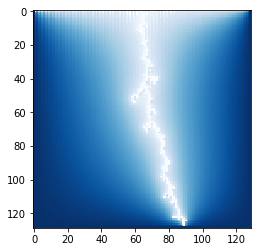

In [13]:
b = boundary2((129, 129))
Phis_dbm, Phis_vis_dbm = gen_arc(b, method='ipcg', also=True, eta=3)
movie(np.sqrt(Phis_vis_dbm), iskwargs={'cmap': 'Blues'}, interval=5)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


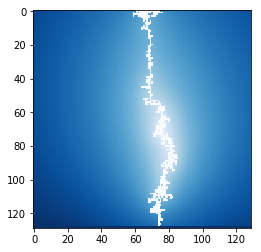

In [14]:
Phis_dbmi = gen_arc_fast(b, eta=6)
movie(np.sqrt(Phis_dbmi), iskwargs={'cmap': 'Blues'}, interval=5)

In [ ]:
Phis_dla = dla(b, n=1000, tip_bias=3)
movie(Phis_dla != 0, iskwargs={'cmap': 'Blues'}, interval=5)

### Adaptive mesh refinement for future work

In [ ]:
# Richardson extrapolation error, used for adaptive mesh
def richardson(A, Q2):
    return  np.abs(Q2.dot(A.flatten())).reshape(A.shape) / (2 ** 3 - 2)


# find first index of first nonzero element
def first_nonzero(x):
    return next((i for i, v in enumerate(x) if v != 0), None)


# slice along an axis
def slice_axis(axis, *args):
    return (slice(None),) * axis + (slice(*args),)


# Find a cut for the grid given 
def find_cut(grid, sigs, slice_idx, min_efficiency=0.5):
    grid = grid[slice_idx]
    sigs = [sig[s] for sig, s in zip(sigs, slice_idx)]
    # Don't cut if already a very efficient grid
    if np.sum(grid) >= grid.size * min_efficiency:
        return None
    
    # try to cut by signature
    for axis, sig in enumerate(sigs):
        cut_idx = first_nonzero(np.diff((sig != 0).astype(int)) > 0)
        if cut_idx is not None:
            cut = (axis, cut_idx)
     
    # cut by zero crossing if no signature cut
    if not cut:
        weights = [1, -2, 1]
        crossing = (None, 0, -np.inf)
        for axis, sig in enumerate(sigs):
            if len(sig) >= len(weights):
                second_deriv = np.pad(np.correlate(sig, weights), (1, 1), 'edge')
                crosses = np.nonzero(np.diff(np.sign(second_deriv)))[0]
                if crosses.size > 0:
                    sizes = np.abs(np.diff(second_deriv)[crosses])
                    amax = sizes.argmax()
                    cross = crosses[amax] + 1
                    new_crossing = (axis, cross), sizes[amax], -np.abs(len(sig) - cross)
                    crossing = max(crossing, new_crossing, key=operator.itemgetter(1, 2))
        cut = crossing[0]

    # If grid not 50% efficient, bisect in long direction as last resort
    if not cut and np.sum(grid) < grid.size / 2:
        axis = np.array(grid.shape).argmax()
        cut_idx = grid.shape[axis] // 2
        cut = (axis, cut_idx)
        
    return cut

# Recursively cut grid into efficient partitions
def partition(grid):
    if not grid.any():
        return []
    
    axes = range(len(grid.shape))
    sigs = [np.sum(grid, axis=tuple(i for i in axes if not axis == i)) for axis in axes]
    
    slices = [(first_nonzero(s), len(s) - first_nonzero(s[::-1])) for s in sigs]
    slice_idx = tuple(slice(*t) for t in slices)
    
    # Find a cut and, if none, return
    axis, cut_idx = find_cut(grid, sigs, slice_idx) or (None, None)
    if axis is None:
        grid[slice_idx] = 1
        return [grid]
    
    cut_idx += slices[axis][0]
    
    # Slice grid into two at cut_idx along axis
    left = grid[slice_axis(axis, None, cut_idx)]
    right = grid[slice_axis(axis, cut_idx, None)]
    
    # Recursively partition subgrids
    lefts, rights = partition(left), partition(right)
    zleft, zright = np.zeros_like(left), np.zeros_like(right)
    
    # pad left and right partitions with zeros
    left_grids = [np.concatenate((l, zright), axis=axis) for l in lefts]
    right_grids = [np.concatenate((zleft, r), axis=axis) for r in rights]
    
    # Return left and right grids
    return left_grids + right_grids


# partition at multiple levels given masks indicating where to refine, as described by Berger/Oliger
def multi_level_partition(masks, exclude=None, min_grid_size=3):
    struct = np.ones((3,) * len(masks[0].shape))
    
    # Include a full grid as the coarsest partition
    old_mask = np.zeros_like(masks[0])
    levels = [[np.ones_like(masks[0])]]
    
    for mask in masks:
        if exclude is not None:
            mask = np.logical_and(1 - exclude, mask)
        
        # Binary dilation of old mask to pad each partition level by one for refluxing
        old_mask = np.logical_or(binary_dilation(old_mask, structure=struct), mask)
        
        # get list of partitions for this level as list, filtering by min_grid_size
        level = [i for i in partition(old_mask) if np.count_nonzero(i) >= min_grid_size]
        levels.append(level)
        
    # return list of levels, each level a list of partition masks at that level
    return levels


def plot_levels(levels):
    return np.sum(sum(levels, []), axis=0) - 1